In [117]:

using Pkg
Pkg.add("Plots")
using Plots
using Optim


   Resolving package versions...
  No Changes to `C:\CMU_Spring\OptimalSailboat\Project.toml`
  No Changes to `C:\CMU_Spring\OptimalSailboat\Manifest.toml`


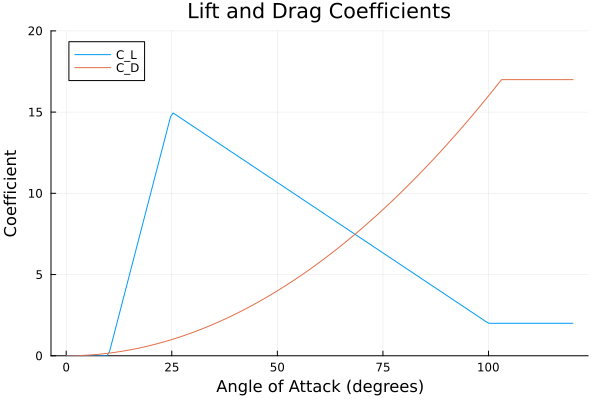

In [118]:
# Refering the following paper for the model
# Roll Stabilization Control of Sailboats
# https://www.sciencedirect.com/science/article/pii/S2405896316320833

# Assuming Constant Wind Speed
V_ws = 5.0  # m/s, example constant wind speed
# Setting some global variables for the sailboat
A = 1  # m^2, sail area
l1 = 1  # m, distance from the center of mass to the sail
l2 = 1  # m, distance from the center of mass to the rudder
h = 1  # m, height of the sail



function angle_of_attack(λ, βws)
    # Calculate the angle of attack
    α = βws - λ + π
    return α
end

# Taken from wikipedia page on lift and drag coefficients
# https://en.wikipedia.org/wiki/Forces_on_sails
function CL(α)
    α_d = rad2deg(α)  # Convert angle from radians to degrees for the calculations
    if α_d <= 10
        return 0.0
    elseif α_d <= 25
        # Linearly increase CL from 0 at 10 degrees to 1.5 at 25 degrees
        return (α_d - 10) * (1.5 / (25 - 10)) * 10
    else
        # Linearly decrease CL from 1.5 at 25 degrees to 0.2 at 100 degrees
        return max(1.5 - (α_d - 25) * ((1.5 - 0.2) / (100 - 25)), 0.2) * 10
    end
end

# Drag coefficient CD as a function of angle of attack α in radians
function CD(α)
    α_d = rad2deg(α)  
    # Quadratic increase to reach 1.6 at 100 degrees
    return min((α_d^2) * (1.6 / 100^2), 1.7) * 10
end

α_range = range(0, stop=π/1.5, length=200)
CL_values = [CL(α) for α in α_range]
CD_values = [CD(α) for α in α_range]

# Plot the coefficients to visualize the lift and drag
p = plot(rad2deg.(α_range), CL_values, label="C_L", xlabel="Angle of Attack (degrees)", ylabel="Coefficient", title="Lift and Drag Coefficients", ylims=(0,20))
plot!(rad2deg.(α_range), CD_values, label="C_D", ylims=(0,20))
display(p)


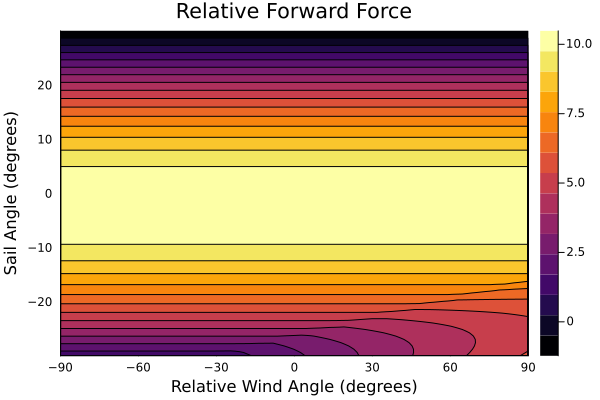

30.625000000000004

In [119]:

function SL_(Vws, A,λ, βws)
    # Calculate the lift force
    ρ = 1.225  # kg/m^3, air density
    Fl = 0.5 * ρ * Vws^2 * A * CL(angle_of_attack(λ, βws))
    return Fl

end

using Plots



function SD_(Vws, A, λ, βws)
    # Calculate the drag force
    ρ = 1.225  # kg/m^3, air density
    Fd = 0.5 * ρ * Vws^2 * A * CD(angle_of_attack(λ, βws))
    return Fd
end

print(SL_(5, 1, 0, 0))


function Sail_forces(Vws, A, λ, βws, h,l1,l2)
    # Calculate the forces on the sail
    SL = SL_(Vws, A, λ, βws)
    SD = SD_(Vws, A, λ, βws)
    S1 = -SL * sin(βws) + SD * cos(βws)
    S2 = SL * cos(βws) + SD * sin(βws)
    S3 = h*S2
    S4 = S1*(l2 * sin(λ))- S2*(l1 + l2 * cos(λ))

    S = [S1, S2, S3, S4]'
    return S
end

# Function to calculate S'_{x,r}
function S_prime_x_r(Vws, A, λ, βws, h, l1, l2)
    S = Sail_forces(Vws, A, λ, βws, h, l1, l2)
    # Here S[1] represents S1, the force in the surge direction
    S_prime_x_r = S[1] / Vws^2
    return S_prime_x_r
end

# Create ranges for relative wind angle and sail angle
βws_values = range(deg2rad(-90), deg2rad(90), length=100)  # Relative wind angle
λ_values = range(deg2rad(-30), deg2rad(30), length=100)    # Sail angle

# Compute the normalized forces for the contour plot
Z = [S_prime_x_r(V_ws, A, λ, βws, h, l1, l2) for βws in βws_values, λ in λ_values]

# Create a contour plot of the relative forward force
p = contour(βws_values .* 180 / π, λ_values .* 180 / π, Z,
            title="Relative Forward Force",
            xlabel="Relative Wind Angle (degrees)",
            ylabel="Sail Angle (degrees)",
            fill=true)

# Display the plot
display(p)


# To find the optimal sail angle, we will optimize over S'_x_r for a given wind speed to find the optimal sail angle defined: λ_opt




In [120]:

# Defining the bounds for the sail angle λ based on the wind angle βws and the saturation limit λ_sat
function λ_bounds(βws, λ_sat)
    if βws < 0
        λ_u = βws + π
        λ_l = 0
    elseif βws > 0
        λ_u = 0
        λ_l = βws - π
    else # Handling the case when βws is 0
        λ_u = 0
        λ_l = -π
    end
    # Apply saturation limits
    λ_u = min(λ_u, λ_sat)
    λ_l = max(λ_l, -λ_sat)
    return λ_l, λ_u
end

function compute_lookup_table(V_ws, A, h, l1, l2, βws_values, λ_sat, verbose=false)
    # Create a lookup table to store the optimal sail angle for each wind angle
    λ_opt_values = Dict()

    # Iterate through all wind angles βws
    for βws in βws_values
        # Get the bounds for λ
        λ_l, λ_u = λ_bounds(βws, λ_sat)
        

        # Optimize to find λ that maximizes S'_x_r within the bounds
        opt_result = optimize(λ -> -S_prime_x_r(V_ws, A, λ, βws, h, l1, l2), λ_l, λ_u)
        # opt_result = optimize(λ -> -S_prime_x_r(V_ws, A, λ, βws, h, l1, l2), -π, π)
        λ_opt = opt_result.minimizer
        if verbose
            force = S_prime_x_r(V_ws, A, λ_opt, βws, h, l1, l2)
            println("βws: ", βws, " λ_l: ", λ_l, " λ_u: ", λ_u, " λ_opt: ", λ_opt, " S'_x_r: ", force)
        end
        # Store the result in the lookup table
        λ_opt_values[βws] = λ_opt
    end
    return λ_opt_values
end


compute_lookup_table (generic function with 4 methods)

In [121]:
λ_sat = π / 8  # standatd saturation limit for the sail angle
βws_values = range(deg2rad(-180), stop=deg2rad(0), length=360) # Wind angles from -180 to 180 degrees in radians

optimal_angle = compute_lookup_table(V_ws, A, h, l1, l2, βws_values, λ_sat, true)


βws: -3.141592653589793 λ_l: 0.0 λ_u: 0.0 λ_opt: 0.0 S'_x_r: 0.0
βws: -3.1328416991229693 λ_l: 0.0 λ_u: 0.008750954466823835 λ_opt: 0.008750954335103306 S'_x_r: -5.581627819689922e-20
βws: -3.1240907446561454 λ_l: 0.0 λ_u: 0.01750190893364767 λ_opt: 0.01750190867020639 S'_x_r: -2.2324021906902476e-19
βws: -3.115339790189321 λ_l: 0.0 λ_u: 0.02625286340047195 λ_opt: 0.026252863005309917 S'_x_r: -5.021948880127506e-19
βws: -3.1065888357224973 λ_l: 0.0 λ_u: 0.03500381786729578 λ_opt: 0.035003817340413 S'_x_r: -8.925520769958116e-19
βws: -3.0978378812556735 λ_l: 0.0 λ_u: 0.04375477233411962 λ_opt: 0.043754771675516085 S'_x_r: -1.3941304490091407e-18
βws: -3.0890869267888497 λ_l: 0.0 λ_u: 0.05250572680094345 λ_opt: 0.05250572601061917 S'_x_r: -2.0067027177384248e-18
βws: -3.0803359723220254 λ_l: 0.0 λ_u: 0.06125668126776773 λ_opt: 0.061256680345722694 S'_x_r: -2.7299855368864787e-18
βws: -3.0715850178552015 λ_l: 0.0 λ_u: 0.07000763573459157 λ_opt: 0.07000763468082578 S'_x_r: -3.5636459483680

Dict{Any, Any} with 360 entries:
  -1.69769  => 0.392699
  -1.26014  => 0.392699
  -0.936352 => 0.149998
  -2.85281  => 0.288781
  -2.57278  => 0.13248
  -0.148766 => 0.149998
  -1.3739   => 0.392699
  -2.05647  => 0.392699
  -0.770084 => 0.149998
  -0.971356 => 0.149998
  -1.76769  => 0.392699
  -2.42401  => 0.281246
  -1.92521  => 0.392699
  -0.726329 => 0.149998
  -2.67779  => 0.0274683
  -0.945103 => 0.149998
  -3.09784  => 0.0437548
  -2.44152  => 0.263744
  -1.25139  => 0.392699
  ⋮         => ⋮

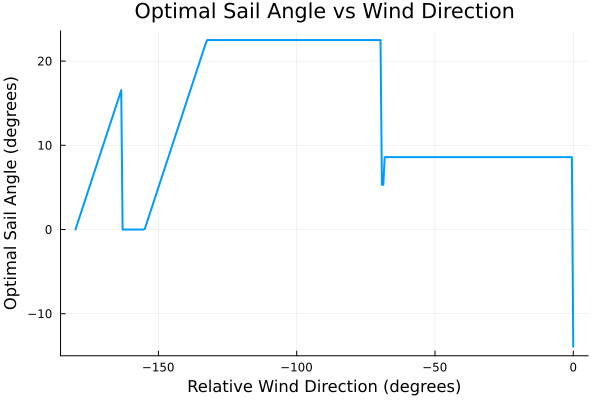

In [125]:

βws_degrees = rad2deg.(collect(keys(optimal_angle)))  # Convert wind direction from radians to degrees
λ_opt_degrees = rad2deg.(collect(values(optimal_angle)))  # Convert sail angle from radians to degrees


sorted_indices = sortperm(βws_degrees)
βws_degrees_sorted = βws_degrees[sorted_indices]
λ_opt_degrees_sorted = λ_opt_degrees[sorted_indices]


line_plot = plot(βws_degrees_sorted, λ_opt_degrees_sorted, title="Optimal Sail Angle vs Wind Direction", xlabel="Relative Wind Direction (degrees)", ylabel="Optimal Sail Angle (degrees)", legend=false, linewidth=2)
display(line_plot)

# This plot follows similarly to the one in the paper, although their lift and drag coefficients seem more refined. They reference a paywall text for the coefficients, so I am unable to access it.
